   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

C:\Users\hp\AppData\Local\Temp\ipykernel_16952\2711349390.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)
c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:16:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Logistic Regression ---
Accuracy: 0.7998580553584103
ROC-AUC: 0.7194747991423183
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.64      0.55      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



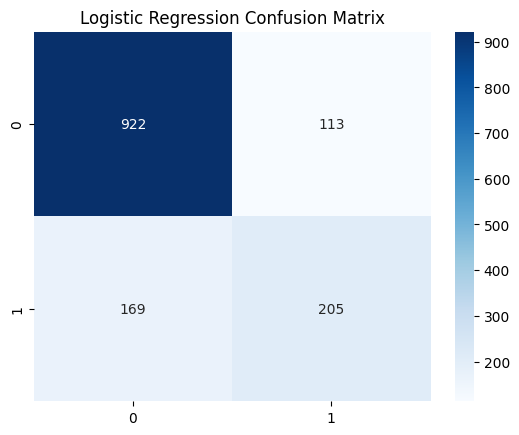

--- Random Forest ---
Accuracy: 0.78708303761533
ROC-AUC: 0.6919954015861943
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



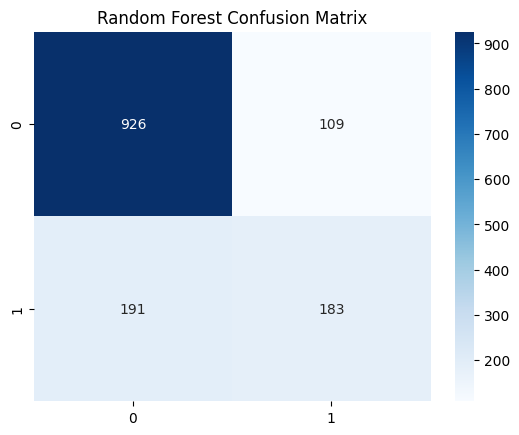

--- XGBoost ---
Accuracy: 0.7835344215755855
ROC-AUC: 0.6964103955152549
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.86      1035
           1       0.61      0.51      0.56       374

    accuracy                           0.78      1409
   macro avg       0.72      0.70      0.71      1409
weighted avg       0.77      0.78      0.78      1409



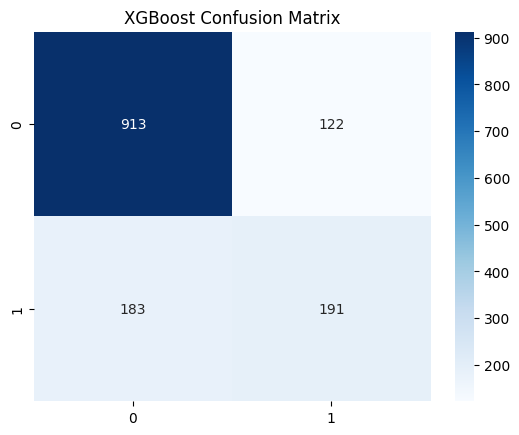

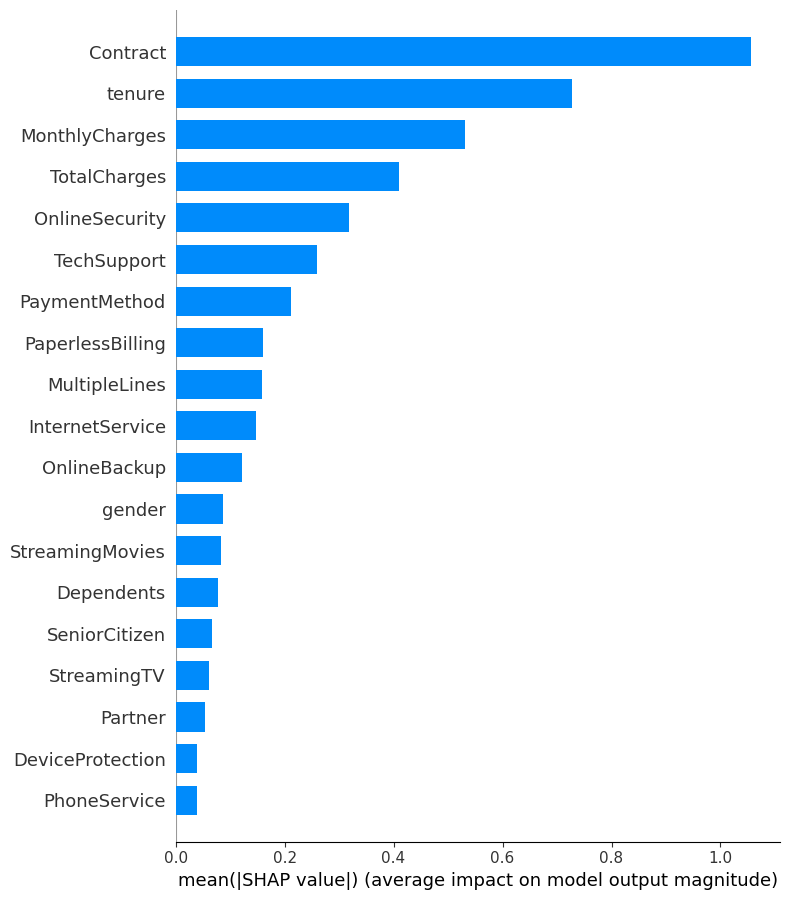

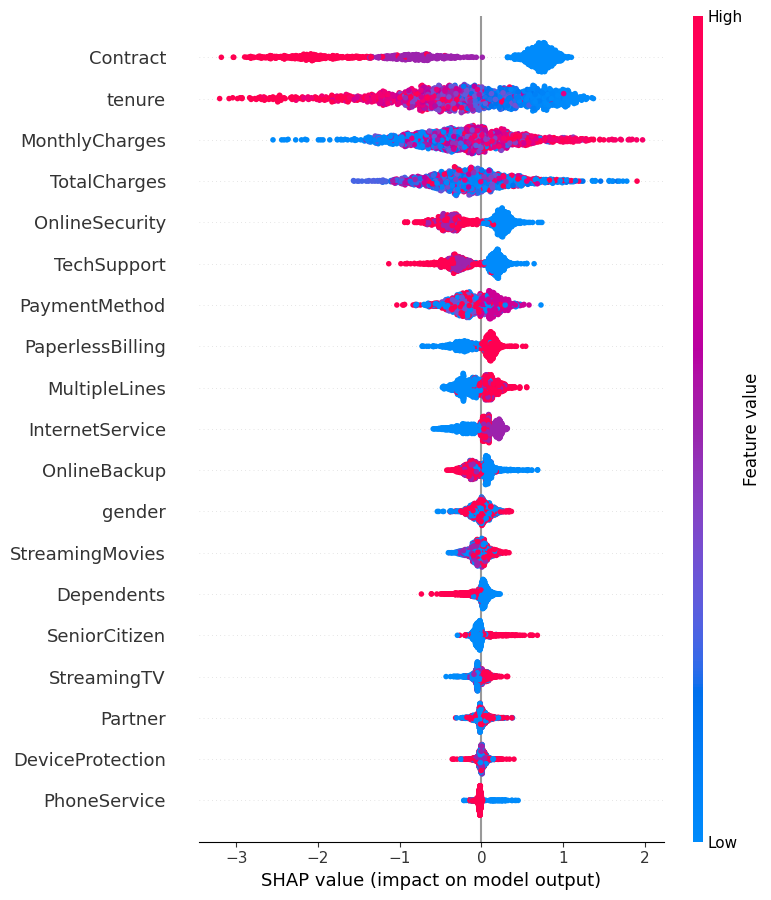

In [ ]:
# -----------------------------
# Telecom Customer Churn Prediction
# -----------------------------

# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import shap



# -----------------------------
# Step 1: Load Dataset
# -----------------------------
df = pd.read_csv('data.csv')

# Quick look
print(df.head())
print(df.info())

# -----------------------------
# Step 2: Data Preprocessing
# -----------------------------

# Drop customerID (not useful)
df.drop('customerID', axis=1, inplace=True)

# Convert total charges to numeric (may have spaces)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill missing TotalCharges with 0
df['TotalCharges'].fillna(0, inplace=True)

# Encode target variable
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

# Encode categorical features
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Scale numerical features
num_cols = ['tenure','MonthlyCharges','TotalCharges']
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# -----------------------------
# Step 3: Train-Test Split
# -----------------------------
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# -----------------------------
# Step 4: Model Training
# -----------------------------

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# -----------------------------
# Step 5: Model Evaluation
# -----------------------------
def evaluate_model(y_true, y_pred, model_name):
    print(f"--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("ROC-AUC:", roc_auc_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

evaluate_model(y_test, y_pred_lr, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")

# -----------------------------
# Step 6: Feature Importance (SHAP for XGBoost)
# -----------------------------
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)



# -----------------------------
# Step 8: Save the Best Model
# -----------------------------
import pickle
pickle.dump(xgb_model, open("xgb_model.pkl", "wb"))

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

C:\Users\hp\AppData\Local\Temp\ipykernel_16952\3114612533.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)


Original class distribution:
 Churn
0    4139
1    1495
Name: count, dtype: int64
After SMOTE:
 Churn
0    4139
1    4139
Name: count, dtype: int64


c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:20:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Logistic Regression ---
Accuracy: 0.7324343506032647
ROC-AUC: 0.7410318013898576
Classification Report:
               precision    recall  f1-score   support

    No Churn       0.89      0.72      0.80      1035
       Churn       0.50      0.76      0.60       374

    accuracy                           0.73      1409
   macro avg       0.69      0.74      0.70      1409
weighted avg       0.79      0.73      0.75      1409



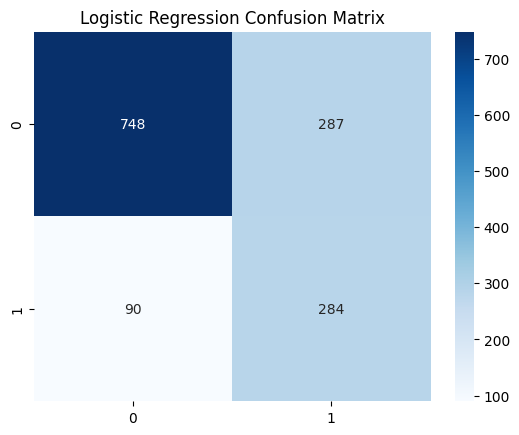

--- Random Forest ---
Accuracy: 0.7693399574166075
ROC-AUC: 0.7311465033971428
Classification Report:
               precision    recall  f1-score   support

    No Churn       0.87      0.81      0.84      1035
       Churn       0.56      0.65      0.60       374

    accuracy                           0.77      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.78      0.77      0.77      1409



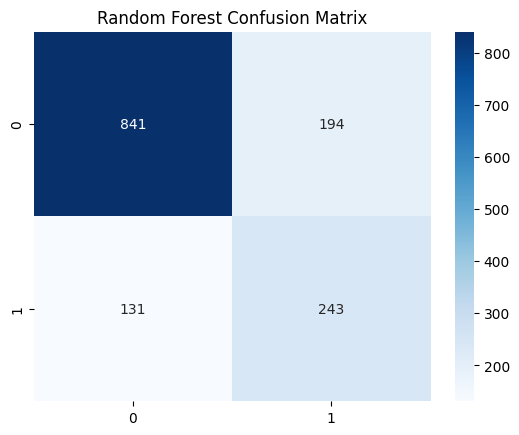

--- XGBoost ---
Accuracy: 0.7721788502484032
ROC-AUC: 0.7441783564545713
Classification Report:
               precision    recall  f1-score   support

    No Churn       0.88      0.80      0.84      1035
       Churn       0.56      0.68      0.61       374

    accuracy                           0.77      1409
   macro avg       0.72      0.74      0.73      1409
weighted avg       0.79      0.77      0.78      1409



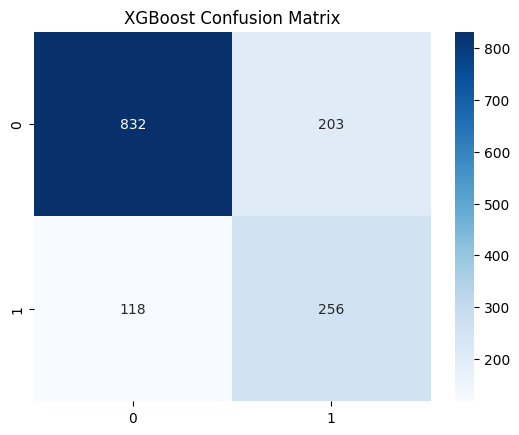

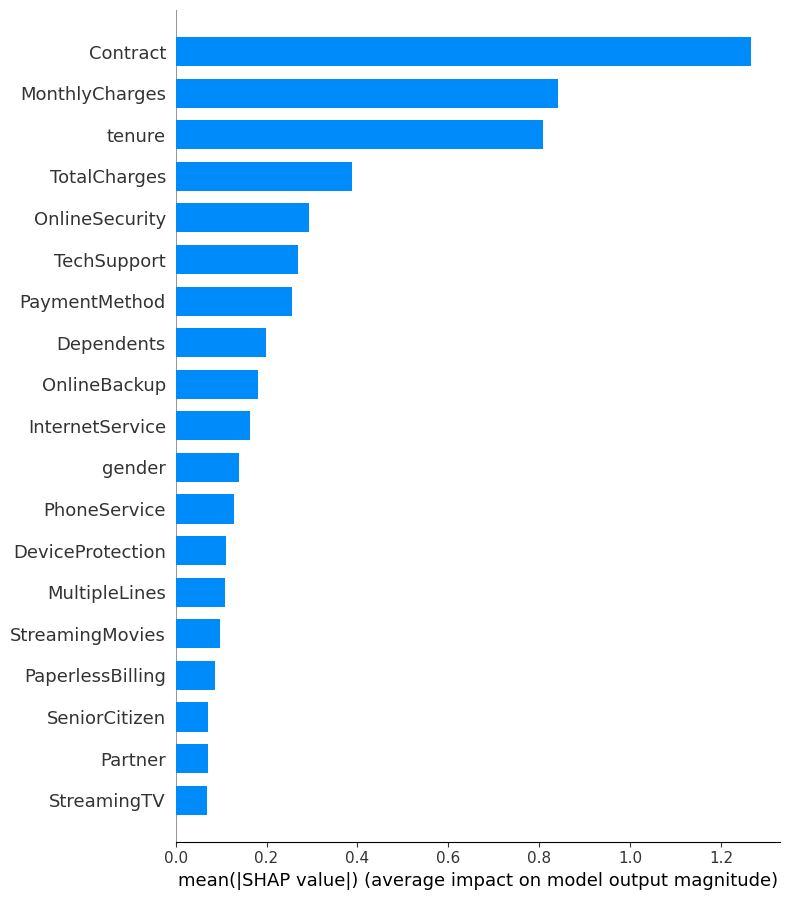

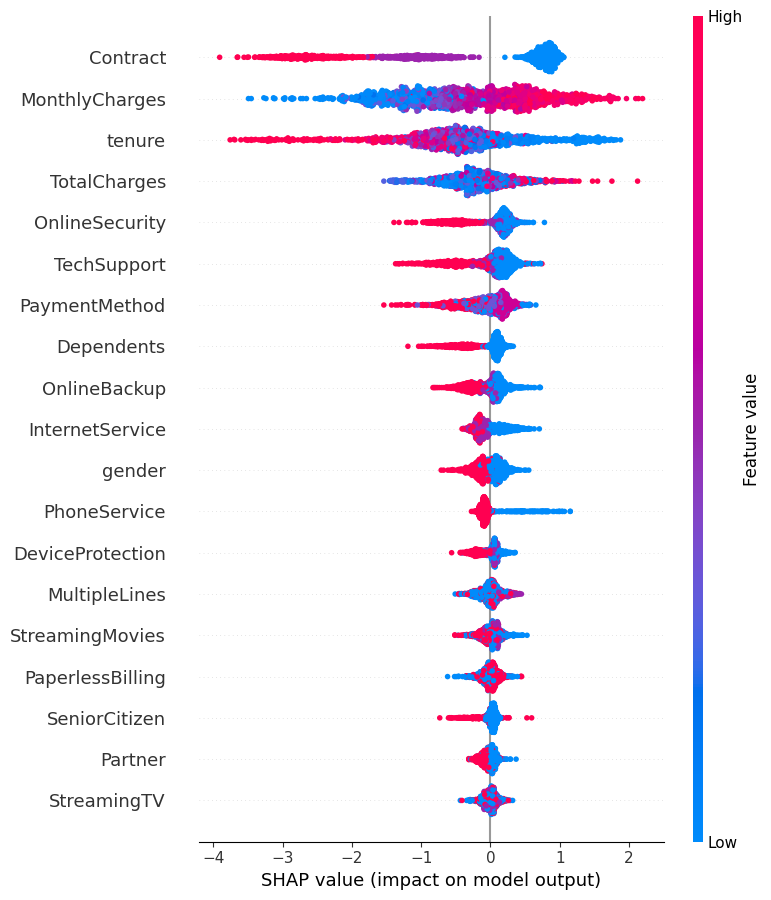

In [4]:
# -----------------------------
# Telecom Customer Churn Prediction with SMOTE
# -----------------------------

# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from imblearn.over_sampling import SMOTE
import shap
import pickle

# -----------------------------
# Step 2: Load Dataset
# -----------------------------
df = pd.read_csv('data.csv')  # Replace with your dataset path

# Quick look
print(df.head())
print(df.info())

# -----------------------------
# Step 3: Data Preprocessing
# -----------------------------

# Drop customerID (not useful)
df.drop('customerID', axis=1, inplace=True)

# Convert TotalCharges to numeric (may have spaces)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill missing TotalCharges with 0
df['TotalCharges'].fillna(0, inplace=True)

# Encode target variable
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

# Encode categorical features
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Scale numerical features
num_cols = ['tenure','MonthlyCharges','TotalCharges']
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# -----------------------------
# Step 4: Train-Test Split
# -----------------------------
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# Step 4.1: Handle Class Imbalance with SMOTE
# -----------------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Original class distribution:\n", y_train.value_counts())
print("After SMOTE:\n", pd.Series(y_train_res).value_counts())

# -----------------------------
# Step 5: Model Training
# -----------------------------

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_res, y_train_res)
y_pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_res, y_train_res)
y_pred_xgb = xgb_model.predict(X_test)

# -----------------------------
# Step 6: Model Evaluation
# -----------------------------
def evaluate_model(y_true, y_pred, model_name):
    print(f"--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("ROC-AUC:", roc_auc_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['No Churn','Churn']))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

evaluate_model(y_test, y_pred_lr, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")

# -----------------------------
# Step 7: Feature Importance (SHAP for XGBoost)
# -----------------------------
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

# -----------------------------
# Step 8: Save the Best Model
# -----------------------------
pickle.dump(xgb_model, open("xgb_model.pkl", "wb"))


In [10]:
!streamlit run app.py



^C



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8503
  Network URL: http://172.23.4.44:8503



Fatal Python error: _PySemaphore_Wakeup: parking_lot: ReleaseSemaphore failed
Python runtime state: initialized

Thread 0x00002c94 (most recent call first):
  File "C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\watchdog\observers\api.py", line 385 in dispatch_events
  File "C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\watchdog\observers\api.py", line 213 in run
  File "C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\threading.py", line 1041 in _bootstrap_inner
  File "C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\threading.py", line 1012 in _bootstrap

Thread 0x00004cbc (most recent call first):
  File "C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\threading.py", line 1092 in join
  File "C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\watchdog\observers\api.py", line 239 in _remove_emitter
  File "C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\watchdog\observers\ap